<a href="https://colab.research.google.com/github/mehrdadkazemi254/MachineLearning/blob/main/Chapter3_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml

In [ ]:
mnist = fetch_openml('mnist_784')

In [ ]:
X, y = mnist['data'] , mnist['target']
print(f"X_shape: {X.shape}, y_shape: {y.shape}")

X_shape: (70000, 784), y_shape: (70000,)


In [ ]:
some_digit = X.iloc[0]
some_digit = some_digit.to_numpy()
print(some_digit.shape)
some_digit = some_digit.reshape(28,28)
print(some_digit.shape)

(784,)
(28, 28)


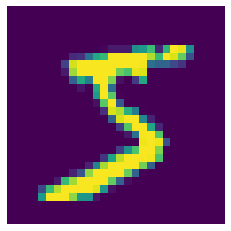

In [ ]:
plt.imshow(some_digit, )
plt.axis('off')
plt.show()

In [ ]:
y[0]

'5'



---



---



In [ ]:
#for convenience, we use the already uploaded datesets on colab
test_set = pd.read_csv('/content/sample_data/mnist_test.csv')
train_set = pd.read_csv('/content/sample_data/mnist_train_small.csv')

In [ ]:
X_train = train_set.drop(train_set.columns[0],axis=1)
X_test = test_set.drop(test_set.columns[0],axis=1)

y_train = train_set[train_set.columns[0]]
y_test = test_set[test_set.columns[0]]

In [ ]:
#shuffle index
shuffle_index = np.random.permutation(len(X_train))
X_train, y_train = X_train.iloc[shuffle_index], y_train.iloc[shuffle_index]

let's first make a binary classifier just for the digit 5

In [ ]:
y_train_5 = y_train == 5
y_test_5 = y_test == 5
type(y_train_5)

pandas.core.series.Series

In [ ]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [ ]:
sgd_clf.predict([X.iloc[0]])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([ True])

In [ ]:
#writing cross validation from scratch

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

sss = StratifiedKFold(n_splits=3, shuffle=True,random_state=42)
#we are spliting the original training set into train and validation(test) sets
for train_index, test_index in sss.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train.iloc[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train.iloc[test_index]
  y_test_fold = y_train_5[test_index]
  
  clone_clf.fit(X_train_folds,y_train_folds)
  pred = clone_clf.predict(X_test_fold)
  n_correct = sum(pred == y_test_fold)
  print(n_correct / len(y_test_fold))

0.7133643317834109
0.8148814881488149
0.8552355235523552


In [ ]:
#now lets do it with the sklearn cross_val_score function

from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.96475176, 0.96279628, 0.95994599])

In [ ]:
#the accuracies above are promising. or are they? lets make a classifier that just says no to everything.literally.

from sklearn.base import BaseEstimator
class Never5(BaseEstimator):
  def fit(self, X, y=None):
    pass
  def predict(self, X, y=None):
    return(np.zeros((len(X),1), dtype=bool))

never5_cls = Never5()
cross_val_score(never5_cls,X_train, y_train_5, cv=3, scoring='accuracy')

# this amazing results is because only 10% of the data belongs to the digit 5.
# that is why accuracy is not a good metric for classifiers.

array([0.90880456, 0.9110411 , 0.9159916 ])

**Confusion Matrix**

In [ ]:
#to make a confusion matrix we need a set of predictions
from sklearn.model_selection import cross_val_predict
pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
pred

array([False, False, False, ..., False, False, False])

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,pred)

array([[18024,   214],
       [  536,  1225]])

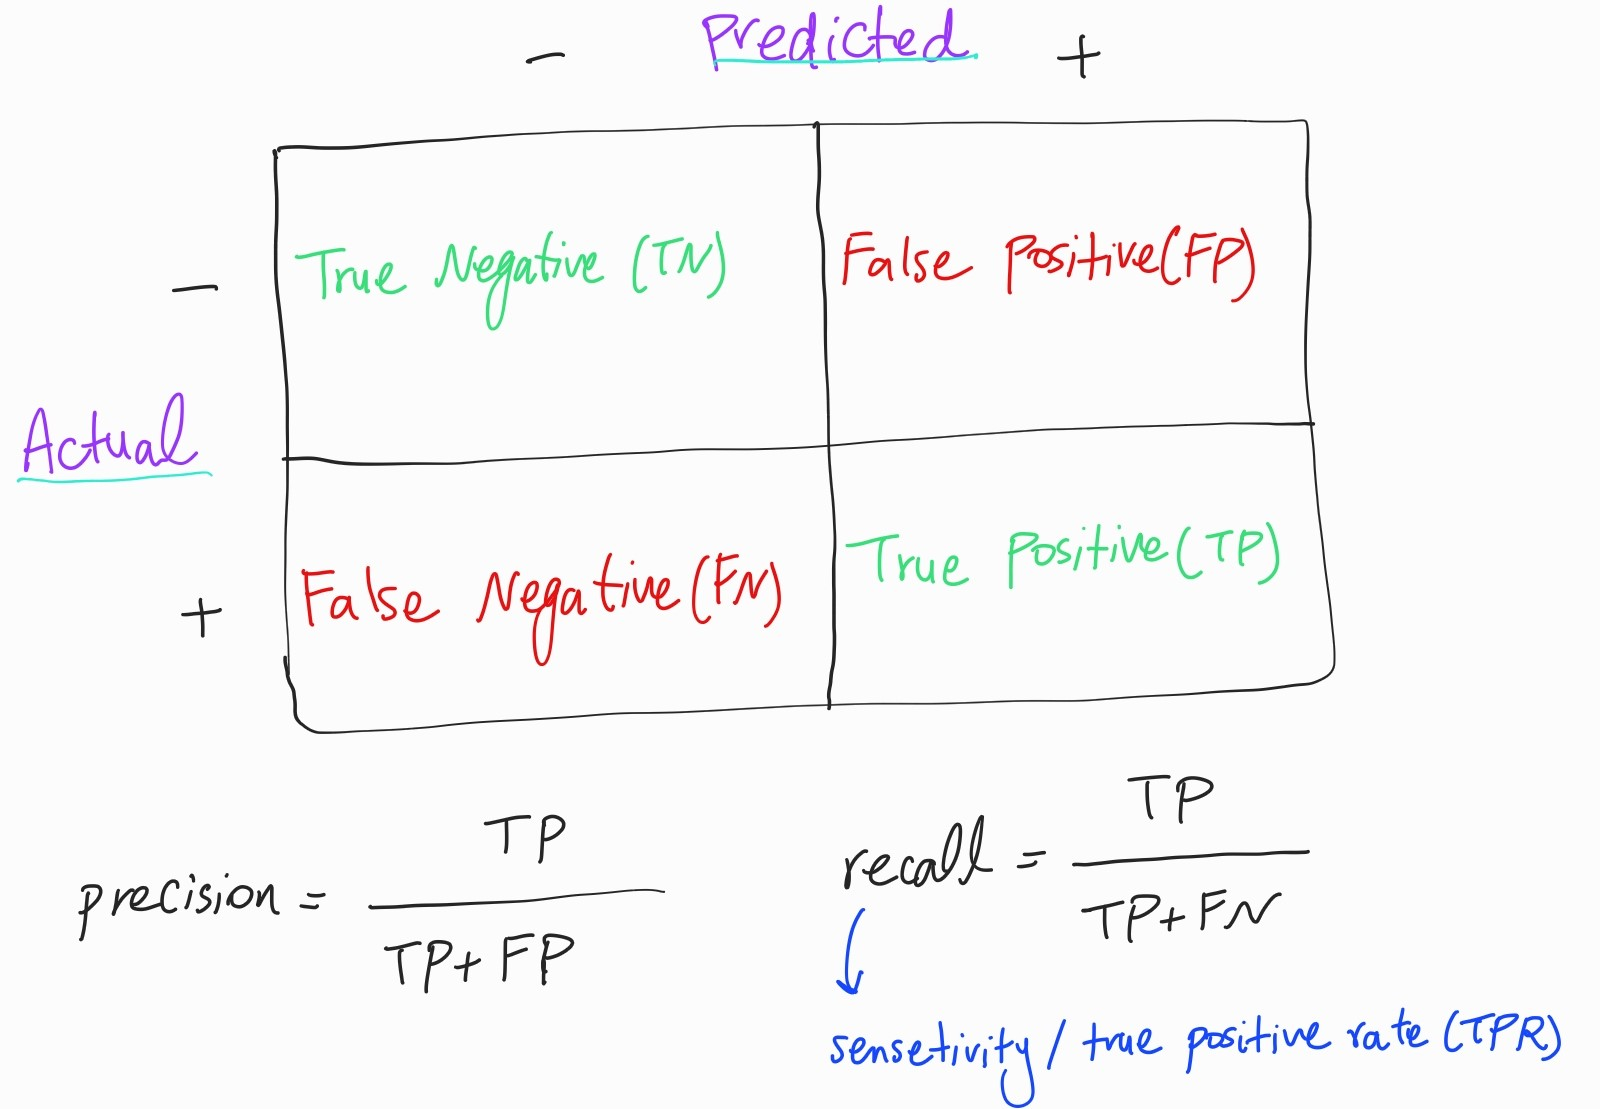

In [ ]:
confusion_matrix(y_train_5,pred)
#precision = 1404/(1404+360) 
#sensetivity = 1404/(1404+357)

array([[18024,   214],
       [  536,  1225]])

In [ ]:
from sklearn.metrics import precision_score, recall_score
prec_scr = precision_score(y_train_5,pred)
recall_scr = recall_score(y_train_5,pred)
print(f"the precision score is {prec_scr} and the recall score is {recall_scr}")
print('\n')
print(f"this means that our classifier is correct {prec_scr*100}% of the time, and can only detect {recall_scr*100}% of 5s")

the precision score is 0.8512856150104239 and the recall score is 0.6956274843838728


this means that our classifier is correct 85.12856150104238% of the time, and can only detect 69.56274843838727% of 5s


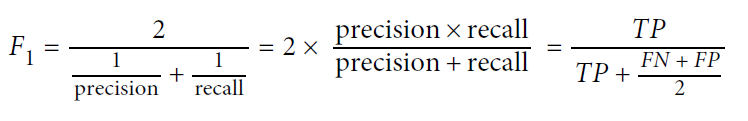

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_train_5,pred)
#the F1 score favors classifiers with similar precision and recall

0.765625

Precision/Recall tradeoff

In [ ]:
sgd_clf.decision_function([X_train.iloc[0]])
# the defalut threshold is 0

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([-32527.76683931])

# **How do we decide which threshold to use?**

1. get the scores of all the instances in the training set using cross_val_predict function and method='decision_function' or 'predict_proba'
2. precision_recall_curve() funtion
3. plot precision and recall as a function of threshold( we can also directly plot precision against racall ) 

In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [ ]:
#PRT
from sklearn.metrics import precision_recall_curve
precisions, recall, threshold = precision_recall_curve(y_train_5,y_scores)

In [ ]:
recall[:-1].shape == threshold.shape

True

In [ ]:
def plot_pr_rc_thr(precisions,recall,thresholds):
  plt.plot(thresholds,precisions[:-1],label="Precision")
  plt.plot(thresholds,recall[:-1],label="Recall")
  plt.xlabel("Threshold")
  plt.legend(loc='best')
  plt.show()


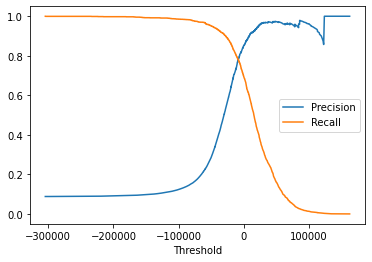

In [ ]:
plot_pr_rc_thr(precisions,recall,threshold)

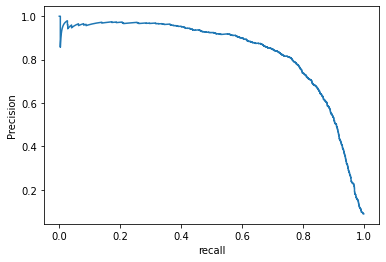

In [ ]:
#we can also plot precision against recall directly
plt.plot(recall,precisions)
plt.ylabel('Precision')
plt.xlabel('recall')
plt.show()

In [ ]:
#we aim the precision of 90% which based on the plot is at around 70 000
prc_90 = y_scores > 15000
precision_score(y_train_5,prc_90)

0.9223697650663942

In [ ]:
recall_score(y_train_5,prc_90)

0.5127768313458262

### **ROC Curve**

In [ ]:
#ROC = TPR/FPR
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5,y_scores)

In [ ]:
def plot_roc(fpr,tpr):
  plt.plot(fpr,tpr,'b',linewidth=2)
  plt.plot([0,1],[0,1],'k--')
  plt.xlabel('false positive rate')
  plt.ylabel('true positive rate')
  

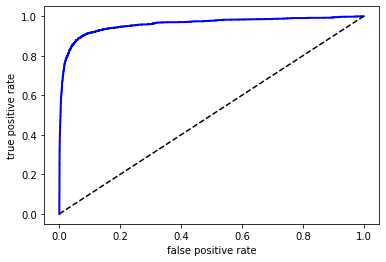

In [ ]:
plot_roc(fpr,tpr)

The dotted line reprsents a purely random classifier. a good classifier stays away from this line and goes towards upper left. hence, one way to compare different classifiers is to compare the area under curve. the perfect classifier would have an area under curve of 1 while a purely random one has 0.5(the dotted line). we achieve this by roc_auc_score()

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5,y_scores)

0.959460995223793

**As a rule of thumb, you should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives, and the ROC curve otherwise.**

In [ ]:
#now let's compare our classifier to a random forest classifier.

from sklearn.ensemble import RandomForestClassifier
random_forest_cls = RandomForestClassifier(random_state=42)
y_probs_rf = cross_val_predict(random_forest_cls, X_train, y_train_5, cv=3, method='predict_proba')

In [ ]:
y_probs_rf.shape
#but we need scores not probabilities

(19999, 2)

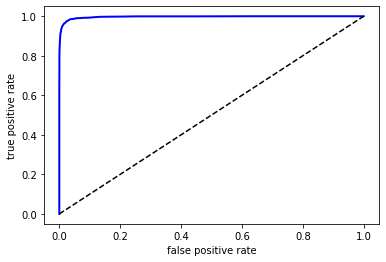

In [ ]:
y_scores_rf = y_probs_rf[:,1]

fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_rf)
plot_roc(fpr_forest, tpr_forest)

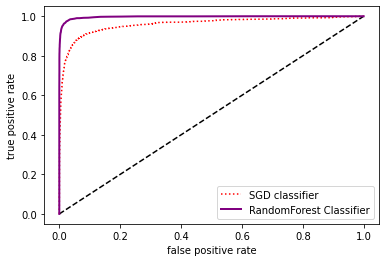

In [ ]:
#now let's compare them together
plt.plot([0,1],[0,1],'k--')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.plot(fpr,tpr,'r:',label="SGD classifier")
plt.plot(fpr_forest,tpr_forest,'purple',linewidth=2 ,label='RandomForest Classifier')
plt.legend(loc='best')
plt.show()

In [ ]:
#the area under ROC curve
print(f'The ROC score is: {roc_auc_score(y_train_5, y_scores_rf)}')

#precision and recall scores
pred_rf = cross_val_predict(random_forest_cls,X_train, y_train_5, cv=3)
print(f"The precision score is {precision_score(y_train_5,pred_rf)}")
print(f"The recall score is {recall_score(y_train_5,pred_rf)}")

The ROC score is: 0.9970927964333537
The precision score is 0.9937282229965156
The recall score is 0.8097671777399205


# Multiclass Classification
two methods:
OvO,
OvA

In [ ]:
#sklearn automatically knows that we are using a binary classifier for multiclass classification, 
#so it runs N of them and returns the results with the highest score
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [ ]:
print(sgd_clf.predict([X.iloc[12]]))
print(y[12])
print('so this prediction was indeed correct.')

[3]
3
so this prediction was indeed correct.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
score_12 = sgd_clf.decision_function([X.iloc[12]])
score_12
# based on this scores, the algo decided that since the highest score belongs to the 3 classifier, the input must be a 3.

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([[-207405.68911745, -126651.90443521,  -36165.56398413,
          59713.96267485, -133604.56455506, -109883.69505945,
        -123308.49380846,  -33543.29020811,  -51817.85460856,
        -100232.96900697]])

In [ ]:
max_arg = np.argmax(score_12) #prints 3
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
sgd_clf.classes_[max_arg]

3

In [ ]:
#now let's do it with OvO which in our case would be (n choose 2) = 45 classifiers.
from sklearn.multiclass import OneVsOneClassifier
one_one_cls = OneVsOneClassifier(sgd_clf)
one_one_cls.fit(X_train,y_train)
one_one_cls.predict([X.iloc[12]])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but OneVsOneClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([3])

In [ ]:
print(one_one_cls.estimators_) #45 classifier
len(one_one_cls.estimators_)

(SGDClassifier(random_state=42), SGDClassifier(random_state=42), SGDClassifier(random_state=42), SGDClassifier(random_state=42), SGDClassifier(random_state=42), SGDClassifier(random_state=42), SGDClassifier(random_state=42), SGDClassifier(random_state=42), SGDClassifier(random_state=42), SGDClassifier(random_state=42), SGDClassifier(random_state=42), SGDClassifier(random_state=42), SGDClassifier(random_state=42), SGDClassifier(random_state=42), SGDClassifier(random_state=42), SGDClassifier(random_state=42), SGDClassifier(random_state=42), SGDClassifier(random_state=42), SGDClassifier(random_state=42), SGDClassifier(random_state=42), SGDClassifier(random_state=42), SGDClassifier(random_state=42), SGDClassifier(random_state=42), SGDClassifier(random_state=42), SGDClassifier(random_state=42), SGDClassifier(random_state=42), SGDClassifier(random_state=42), SGDClassifier(random_state=42), SGDClassifier(random_state=42), SGDClassifier(random_state=42), SGDClassifier(random_state=42), SGDClas

45

In [ ]:
#now, the same thing with the random forest classifier
random_forest_cls.fit(X_train,y_train)
random_forest_cls.predict([X.iloc[12]])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([3])

In [ ]:
random_forest_cls.predict_proba([X.iloc[12]])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([[0.  , 0.  , 0.  , 0.98, 0.  , 0.01, 0.  , 0.  , 0.01, 0.  ]])

In [ ]:
#now let's evaluate all of these classifiers.
cross_val_score(sgd_clf,X_train,y_train,cv=3, scoring='accuracy')
#OvA

array([0.88045598, 0.87323732, 0.86648665])

In [ ]:
cross_val_score(random_forest_cls,X_train,y_train,cv=3, scoring='accuracy')

array([0.95305235, 0.94974497, 0.95649565])

In [ ]:
cross_val_score(one_one_cls,X_train,y_train,cv=3, scoring='accuracy')
#OvO

array([0.91075446, 0.9110411 , 0.91344134])

In [ ]:
#we could acheive even higher scores simply by scaling the X
from sklearn.preprocessing import StandardScaler
my_scaler = StandardScaler()
X_train_scaled = my_scaler.fit_transform(X_train.astype(np.float64))

cross_val_score(sgd_clf,X_train_scaled,y_train,cv=3, scoring='accuracy')

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


array([0.9059547 , 0.90024002, 0.90189019])

# Error Analysis

In [ ]:
y_train_pred = cross_val_predict(sgd_clf,X_train_scaled,y_train,cv=3)
conf_mt = confusion_matrix(y_train,y_train_pred)
conf_mt

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


array([[1864,    0,   12,    2,    4,   21,   15,    4,   39,    1],
       [   1, 2142,   16,   12,    3,   21,    2,    1,   41,    4],
       [  15,   17, 1754,   43,   37,    7,   32,   17,   63,    4],
       [   7,   11,   42, 1758,    0,   82,   11,   16,   65,   29],
       [   7,    9,   19,    3, 1710,    8,   16,   14,   51,   87],
       [  15,    7,   14,   67,   21, 1478,   28,    8,   82,   41],
       [  11,    6,   23,    1,   15,   27, 1933,    1,   21,    0],
       [   4,    6,   19,   14,   20,    2,    1, 1935,   18,  107],
       [   9,   32,   25,   42,    0,   46,   11,    4, 1710,   33],
       [  12,   11,   10,   25,   61,   16,    0,   59,   60, 1769]])

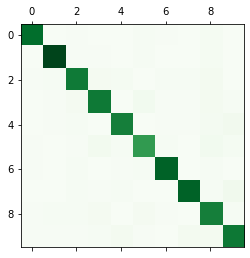

In [ ]:
plt.matshow(conf_mt,cmap=plt.cm.Greens)
plt.show()

In [ ]:
#axis: 0:down 1:across
row_sum = np.sum(conf_mt,axis=1,keepdims=True)
#rows represent actuall classes, while columns represent predictions
row_sum

array([[1962],
       [2243],
       [1989],
       [2021],
       [1924],
       [1761],
       [2038],
       [2126],
       [1912],
       [2023]])

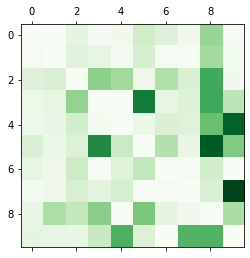

In [ ]:
norm_conf_mt = conf_mt/ row_sum
np.fill_diagonal(norm_conf_mt,0)

plt.matshow(norm_conf_mt,cmap=plt.cm.Greens)
plt.show()

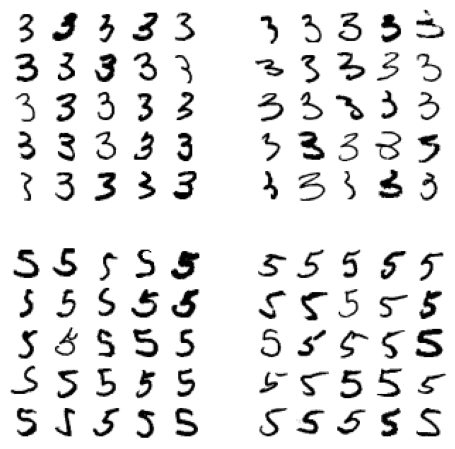

In [ ]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [np.array(instances.iloc[i]).reshape(size, size) for i in range(instances.shape[0])] #change done here
    
    if images_per_row == 0:
       images_per_row = 0.1
    
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = plt.cm.binary, **options)
    plt.axis("off")

cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

In [ ]:
y_train_large = y_train >= 7 # a boolean mask 
y_train_odd = y_train %2 == 1  # a boolean mask
y_multilabel = np.c_[y_train_large, y_train_odd]

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
Knn_clf = KNeighborsClassifier()
Knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [ ]:
print(f" y_train[0] is {y_train[1000]}\n")
Knn_clf.predict([X_train.iloc[1000]])
# the classifier predicted true for the first label (being greater than or equal to 7)
# and true for the second label (being odd)

 y_train[0] is 9



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([[ True,  True]])

In [ ]:
#we can use F1 score to evaluate the classifier
knn_pred = cross_val_predict(Knn_clf, X_train, y_multilabel, cv=3)
print(f"f1 score assuming equal weight for the labels would be: {f1_score(y_multilabel, knn_pred, average='macro')}")
print(f"weighted f1 score would be : {f1_score(y_multilabel, knn_pred, average='weighted')}")

f1 score assuming equal weight for the labels would be: 0.9672976025783757
weighted f1 score would be : 0.9692793496814255
